## Esophagus Classification

### Data Loading and Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import h5py

from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import models
from sklearn.metrics import precision_score, recall_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG19, VGG16, InceptionV3, ResNet50, DenseNet121
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate

In [2]:
data_path = "C:/Users/Mittal/Desktop/esophagus/data/"

classes = os.listdir(data_path)
num_classes = len(classes)
print("Number Of Classes: ", num_classes, classes)

Number Of Classes:  7 ['Achalasia II', 'Achalasia III', 'EGJOO', 'FD', 'HAEC', 'IEM', 'Normals']


In [3]:
data = {}

for i, folder in enumerate(classes):
    files = os.listdir(data_path + folder)
    data[folder] = files

data

{'Achalasia II': ['Aii10_swallows1-10(4,5,7,9,10)_5cc_supine_ROIs.mat',
  'Aii11_swallows1-10(1,2,3,7,9)_5cc_supine_ROIs.mat',
  'Aii12_swallows1-10(3,4,5,6,7)_5cc_supine_ROIs.mat',
  'Aii13_swallows1-10(1,2,4,7,10)_5cc_ltlateral_ROIs.mat',
  'Aii14_swallows1-9(1,2,4,5,6)_5cc_supine_ROIs.mat',
  'Aii15_swallows1-10(2,3,4,5,6)_5cc_ltlateral_ROIs.mat',
  'Aii16_swallows1-10(1,4,5,7,10)_5cc_supine_ROIs.mat',
  'Aii17_swallows1-10(1,3,4,5,8)_5cc_supine_ROIs.mat',
  'Aii18_swallows1-10(5,6,7,8,9)_5cc_supine_ROIs.mat',
  'Aii19_swallows1-10(2,3,5,6,7)_5cc_supine_ROIs.mat',
  'Aii1_swallows1-10(1,2,4,5,8)_5cc_supine_ROIs.mat',
  'Aii20_swallows1-10(2,3,4,7,8)_5cc_supine_ROIs.mat',
  'Aii21_swallows1-10(1,2,3,4,5)_5cc_supine_ROIs.mat',
  'Aii22_swallows1-10(1,6,8,9,10)_5cc_supine_ROIs.mat',
  'Aii23_swallows1-10(1,2,3,4,6)_5cc_supine_ROIs.mat',
  'Aii24_swallows1-10(1,2,3,4,6)_5cc_supine_ROIs.mat',
  'Aii25_swallows1-7(1,4,5,6,7)_5cc_supine_ROIs.mat',
  'Aii26_swallows1-10(1,2,4,5,9)_5cc_supin

In [4]:
pressure_data = []
impedance_data = []               
labels = []

for clas, file in data.items():
    for i in range(len(file)):
        file_path = data_path + clas + '/' + data[clas][i]

        with h5py.File(file_path, 'r') as f:
            roi = f['ROIset']
            pressure_refs = roi['pressure'][:]        
            impedance_refs = roi['impedance'][:]

            for i, ref in enumerate(pressure_refs):
                pressure_obj = f[pressure_refs[i][0]]  
                impedance_obj = f[impedance_refs[i][0]]           
                pressure_arr = pressure_obj[:]
                impedance_arr = impedance_obj[:]
                if pressure_arr.size > 0 and impedance_arr.size > 0:
                    pressure_data.append(pressure_arr.T)
                    impedance_data.append(impedance_arr.T)
                    labels.append(clas)

pressure_data = np.array(pressure_data, dtype=object)
impedance_data = np.array(impedance_data, dtype=object)
labels = np.array(labels)

shapes = np.array([img.shape for img in pressure_data])
target_height = np.max(shapes[:, 0])
target_width = np.max(shapes[:, 1])

print(f"Resizing all images to: {target_height} x {target_width}")

pressure_data_resized = np.array([cv2.resize(img, (target_width, target_height))
                                      for img in pressure_data], dtype='float32')
impedance_data_resized = np.array([cv2.resize(img, (target_width, target_height))
                                       for img in impedance_data], dtype='float32')

X_pressure = pressure_data_resized[..., np.newaxis]
X_impedance = impedance_data_resized[..., np.newaxis]

print("Resized pressure data shape:", pressure_data_resized.shape)
print("Resized impedance data shape:", impedance_data_resized.shape)

Resizing all images to: 27 x 3530
Resized pressure data shape: (1046, 27, 3530)
Resized impedance data shape: (1046, 27, 3530)


In [5]:
pd.DataFrame(pressure_data_resized[-1])

,0,1,2,3,4,5,6,7,8,9,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529
0,25.200001,25.224150,25.343584,25.463017,25.582451,25.701883,25.820000,25.820000,25.820000,25.795992,...,10.409617,10.360000,10.360000,10.360000,10.360000,10.360000,10.360000,10.360000,10.360000,10.360000
1,15.843333,15.837793,15.810396,15.783000,15.757421,15.733020,15.708889,15.708889,15.708889,15.682390,...,9.902189,9.870000,9.870000,9.870000,9.870000,9.870000,9.870000,9.870000,9.870000,9.870000
2,9.675555,9.679191,9.697170,9.715150,9.760482,9.823551,9.885445,9.841781,9.798117,9.726235,...,12.649715,12.632254,12.588590,12.544926,12.501263,12.457599,12.431111,12.431111,12.431111,12.431111
3,5.496666,5.509939,5.575578,5.641216,5.728668,5.830265,5.930017,5.864378,5.798740,5.705832,...,12.159876,12.153795,12.117837,12.081878,12.045919,12.009961,11.988148,11.988148,11.988148,11.988148
4,3.480000,3.492984,3.557195,3.621407,3.671596,3.712691,3.752880,3.711785,3.670689,3.602918,...,10.317063,10.326667,10.326667,10.326667,10.303805,10.280689,10.266666,10.266666,10.266666,10.266666
5,3.847778,3.856751,3.901129,3.945506,3.955173,3.942330,3.929496,3.917367,3.905238,3.869634,...,11.700225,11.735556,11.735556,11.735556,11.665561,11.594786,11.551852,11.551852,11.551852,11.551852
6,3.034074,3.020830,2.955335,2.889839,2.822179,2.753116,2.684119,2.621049,2.557979,2.493901,...,13.221682,13.283334,13.283334,13.283334,13.212774,13.141428,13.098148,13.098148,13.098148,13.098148
7,1.747778,1.734534,1.669038,1.603543,1.539865,1.477365,1.415475,1.408198,1.400921,1.369457,...,12.892886,12.900000,12.900000,12.900000,12.959270,13.019200,13.055555,13.055555,13.055555,13.055555
8,-0.049630,-0.062873,-0.128369,-0.193865,-0.229324,-0.245306,-0.260576,-0.212061,-0.163545,-0.123270,...,16.094444,16.094444,16.094444,16.094444,16.167826,16.242025,16.265707,16.211483,16.157261,16.146296
9,-2.184444,-2.197227,-2.260439,-2.323652,-2.348519,-2.348519,-2.347821,-2.284609,-2.221396,-2.158835,...,13.230705,13.247778,13.247778,13.247778,13.277271,13.307095,13.297287,13.226369,13.155451,13.141111


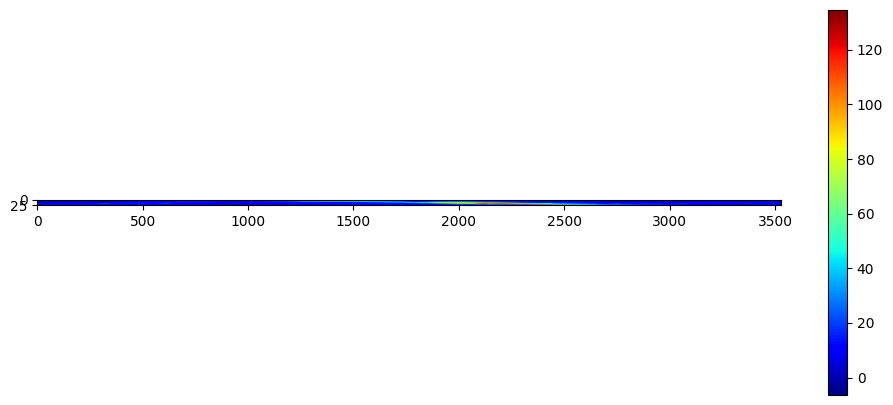

In [6]:
plt.figure(figsize=(12, 5))

# Display the image with the specified colormap
plt.imshow(pressure_data_resized[-1], cmap='jet')
plt.colorbar()
plt.show()

In [7]:
pd.DataFrame(impedance_data_resized[-1])

,0,1,2,3,4,5,6,7,8,9,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529
0,2.481750,2.482295,2.484992,2.487689,2.488633,2.488441,2.488245,2.487763,2.487282,2.486760,...,2.229640,2.227874,2.225948,2.224021,2.226667,2.229364,2.231985,2.234489,2.236994,2.237500
1,2.385500,2.385939,2.388112,2.390284,2.391022,2.390829,2.390636,2.390379,2.390122,2.389732,...,2.159500,2.157835,2.156508,2.155181,2.157463,2.159786,2.162091,2.164371,2.166650,2.167111
2,2.193037,2.193274,2.194448,2.195622,2.195819,2.195384,2.194949,2.194514,2.194078,2.193685,...,2.039148,2.038280,2.038095,2.037910,2.039499,2.041107,2.042716,2.044325,2.045934,2.046259
3,2.082759,2.082783,2.082901,2.083019,2.082799,2.082360,2.081921,2.081435,2.080950,2.080587,...,1.968151,1.968200,1.969049,1.969898,1.970825,1.971752,1.972625,1.973413,1.974202,1.974361
4,2.137500,2.137338,2.136535,2.135732,2.135436,2.135468,2.135499,2.135370,2.135242,2.135033,...,1.991747,1.992530,1.994007,1.995484,1.995944,1.996394,1.996654,1.996622,1.996590,1.996583
5,2.319343,2.319032,2.317498,2.315964,2.315824,2.316588,2.317348,2.317840,2.318333,2.318366,...,2.093040,2.094269,2.095949,2.097630,2.097803,2.097960,2.097776,2.097066,2.096356,2.096213
6,2.522120,2.521731,2.519804,2.517878,2.517822,2.518977,2.520131,2.521109,2.522086,2.522337,...,2.224725,2.225814,2.227224,2.228633,2.228648,2.228648,2.228316,2.227470,2.226625,2.226454
7,2.749139,2.748749,2.746823,2.744897,2.744840,2.745996,2.747153,2.748459,2.749764,2.750208,...,2.391603,2.391872,2.392460,2.393049,2.393055,2.393055,2.392917,2.392564,2.392210,2.392139
8,2.819120,2.818731,2.816804,2.814878,2.814562,2.815289,2.816021,2.817084,2.818147,2.818419,...,2.417681,2.417272,2.417183,2.417094,2.417657,2.418228,2.418685,2.418967,2.419249,2.419306
9,2.739917,2.739527,2.737601,2.735674,2.734852,2.734745,2.734642,2.734920,2.735198,2.734954,...,2.309999,2.309047,2.308416,2.307785,2.309443,2.311127,2.312562,2.313614,2.314667,2.314880


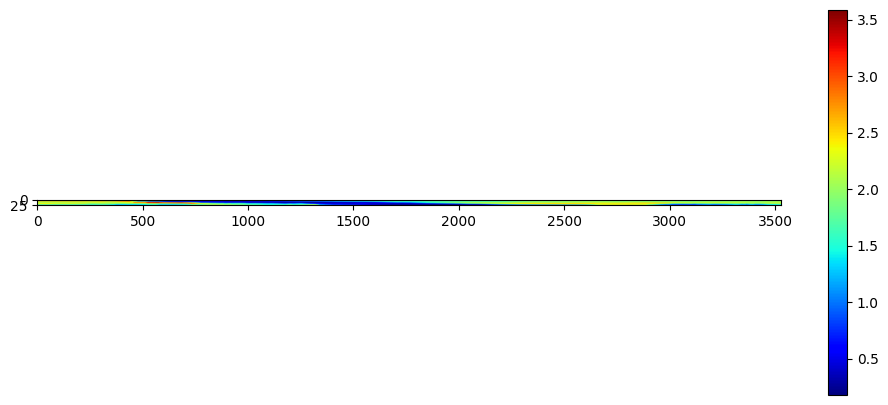

In [8]:
plt.figure(figsize=(12, 5))

# Display the image with the specified colormap
plt.imshow(impedance_data_resized[-1],cmap='jet')
plt.colorbar()
plt.show()

### Training and Validation

In [9]:
from scikeras.wrappers import KerasClassifier
import sklearn
import scikeras
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

In [10]:
def new_model(shape):
    input_shape = (shape[0], shape[1], 1)
    
    # Define the model
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer (adjust the number of units according to your classes)
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def combined_model(shape, num_classes=7):
    # Input shape: (height, width, 2) for pressure + impedance
    input_shape = (shape[0], shape[1], 2)
    
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten features
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def two_branch_model(height, width, num_classes=7):
    # Pressure branch
    input_pressure = Input(shape=(height, width, 1), name='pressure_input')
    x1 = Conv2D(32, (3,3), activation='relu')(input_pressure)
    x1 = MaxPooling2D((2,2))(x1)
    x1 = Conv2D(64, (3,3), activation='relu')(x1)
    x1 = MaxPooling2D((2,2))(x1)
    x1 = Conv2D(128, (3,3), activation='relu')(x1)
    x1 = MaxPooling2D((2,2))(x1)
    x1 = Flatten()(x1)

    # Impedance branch
    input_impedance = Input(shape=(height, width, 1), name='impedance_input')
    x2 = Conv2D(32, (3,3), activation='relu')(input_impedance)
    x2 = MaxPooling2D((2,2))(x2)
    x2 = Conv2D(64, (3,3), activation='relu')(x2)
    x2 = MaxPooling2D((2,2))(x2)
    x2 = Conv2D(128, (3,3), activation='relu')(x2)
    x2 = MaxPooling2D((2,2))(x2)
    x2 = Flatten()(x2)

    # Merge branches
    merged = Concatenate()([x1, x2])

    # Dense layers
    fc = Dense(256, activation='relu')(merged)
    fc = Dropout(0.5)(fc)
    fc = Dense(128, activation='relu')(fc)
    fc = Dropout(0.5)(fc)

    # Output
    output = Dense(num_classes, activation='softmax')(fc)

    model = Model(inputs=[input_pressure, input_impedance], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
def train(shape, model, selection):
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        filepath=f'C:/Users/Mittal/Desktop/esophagus/best_{selection}_model.keras',  # Specify the path to save the best model
        monitor='val_accuracy',
        save_best_only=True,  # Save only the best model
        save_weights_only=False,  # Save the entire model, including architecture
        mode='max',  # Save when val_accuracy is maximized
        verbose=1  # Optional: Display a message when saving the best model
    )

    reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      # metric to monitor
    factor=0.5,              # reduce LR by this factor
    patience=5,              # number of epochs with no improvement before reducing
    verbose=1,               # print message when LR changes
    min_lr=1e-6              # lower bound on learning rate
    )

    fit_callbacks = [early_stopping, model_checkpoint, reduce_lr]
    model = model(shape)

    # return model
    history = model.fit(x=X_train, y=y_train, epochs=100, validation_data = (X_val, y_val), 
                        callbacks=fit_callbacks, verbose=2)
    
def train_two_branch(X_train, X_val, y_train, y_val, height, width, num_classes, model_fn, selection):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        filepath=f'C:/Users/Mittal/Desktop/esophagus/best_{selection}_model.keras',
        monitor='val_accuracy', save_best_only=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
    
    model = model_fn(height, width, num_classes)
    
    history = model.fit(
        [X_train[0], X_train[1]], y_train,
        validation_data=([X_val[0], X_val[1]], y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=2
    )

    
def test_plot(selection):
    # Load the best model saved during training
    best_model = load_model(f'C:/Users/Mittal/Desktop/esophagus/best_{selection}_model.keras')  # Provide the path to the saved best model
    
    # Use the best model for inference or evaluation
    preditions = best_model.predict(X_test)
    y_pred = [np.argmax(prediction) for prediction in preditions]

    # Calculate precision, recall and F1-score
    print(classification_report(y_test, y_pred))

    # Get the confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print('Test accuracy:', accuracy)

    # Compute precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print('Test precision: ', precision)

    recall = recall_score(y_test, y_pred, average='weighted')
    print('Test recall: ', recall)

In [15]:
print("Class labels: ")
for i in range(num_classes):
    print(i, '-', classes[i] )

shape = pressure_data_resized[0].shape

Class labels: 
0 - Achalasia II
1 - Achalasia III
2 - EGJOO
3 - FD
4 - HAEC
5 - IEM
6 - Normals


In [16]:
X_pressure = np.stack(pressure_data_resized, axis=0)
X_pressure = X_pressure[..., np.newaxis] 
X_pressure = X_pressure.astype('float32')

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(X_pressure, 
                                                y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
print(pressure_data.shape, labels.shape, X_train.shape)
X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(X_val.shape)

p_mean = X_train.mean()
p_std  = X_train.std()

# Apply normalization using TRAINING stats
X_train = (X_train - p_mean) / p_std
X_val   = (X_val   - p_mean) / p_std
X_test  = (X_test  - p_mean) / p_std

print("Normalization complete.")
print("Train mean (post):", X_train.mean(), "std:", X_train.std())

(1046,) (1046,) (627, 27, 3530, 1)
(209, 27, 3530, 1)
Normalization complete.
Train mean (post): 9.0920463e-07 std: 1.0000015


In [ ]:
train(shape, new_model, 'pressure')
test_plot('pressure')

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.56459, saving model to C:/Users/Mittal/Desktop/esophagus/best_pressure_model.keras
20/20 - 11s - 570ms/step - accuracy: 0.3030 - loss: 1.8628 - val_accuracy: 0.5646 - val_loss: 1.3011 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_accuracy improved from 0.56459 to 0.57895, saving model to C:/Users/Mittal/Desktop/esophagus/best_pressure_model.keras
20/20 - 9s - 435ms/step - accuracy: 0.4498 - loss: 1.3937 - val_accuracy: 0.5789 - val_loss: 1.0264 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_accuracy improved from 0.57895 to 0.64115, saving model to C:/Users/Mittal/Desktop/esophagus/best_pressure_model.keras
20/20 - 9s - 437ms/step - accuracy: 0.5327 - loss: 1.1889 - val_accuracy: 0.6411 - val_loss: 0.8348 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_accuracy improved from 0.64115 to 0.70335, saving model to C:/Users/Mittal/Desktop/esophagus/best_pressure_model.keras
20/20 - 9s - 431ms/step - accuracy: 0.

In [ ]:
X_impedance = np.stack(impedance_data_resized, axis=0)
X_impedance = X_impedance[..., np.newaxis] 
X_impedance = X_impedance.astype('float32')

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(X_impedance, 
                                                y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
print(pressure_data.shape, labels.shape, X_train.shape)
X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(X_val.shape)

i_mean = X_train.mean()
i_std  = X_train.std()

# Apply z-score using training stats
X_train = (X_train - i_mean) / i_std
X_val   = (X_val   - i_mean) / i_std
X_test  = (X_test  - i_mean) / i_std

print("Impedance normalization complete.")
print("Train mean:", X_train.mean(), "Train std:", X_train.std())

In [ ]:
train(shape, new_model, 'impedance')
test_plot('impedance')

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train_p, X_temp_p, y_train, y_temp = train_test_split(
    X_pressure, y_encoded, test_size=0.4,
    random_state=42, stratify=y_encoded
)

X_val_p, X_test_p, y_val, y_test = train_test_split(
    X_temp_p, y_temp, test_size=0.5,
    random_state=42, stratify=y_temp
)

# Split impedance with same indices by doing a second split
X_train_i, X_temp_i, _, _ = train_test_split(
    X_impedance, y_encoded, test_size=0.4,
    random_state=42, stratify=y_encoded
)

X_val_i, X_test_i, _, _ = train_test_split(
    X_temp_i, y_temp, test_size=0.5,
    random_state=42, stratify=y_temp
)

print(X_val.shape)

p_mean = X_train_p.mean()
p_std  = X_train_p.std()

X_train_p = (X_train_p - p_mean) / p_std
X_val_p   = (X_val_p   - p_mean) / p_std
X_test_p  = (X_test_p  - p_mean) / p_std

i_mean = X_train_i.mean()
i_std  = X_train_i.std()

X_train_i = (X_train_i - i_mean) / i_std
X_val_i   = (X_val_i   - i_mean) / i_std
X_test_i  = (X_test_i  - i_mean) / i_std

X_train = np.concatenate([X_train_p, X_train_i], axis=-1)
X_val   = np.concatenate([X_val_p,   X_val_i],   axis=-1)
X_test  = np.concatenate([X_test_p,  X_test_i],  axis=-1)

In [ ]:
train(shape, combined_model, 'combined')
test_plot('combined')

In [ ]:
X_pressure = pressure_data_resized[..., np.newaxis]
X_impedance = impedance_data_resized[..., np.newaxis]

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train_p, X_temp_p, X_train_i, X_temp_i, y_train, y_temp = train_test_split(X_pressure, X_impedance, 
                                                y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
print(pressure_data.shape, labels.shape, X_train.shape)
X_val_p, X_test_p, X_val_i, X_test_i, y_val, y_test = train_test_split(X_temp_p, X_temp_i, 
                                                y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
height, width = int(X_pressure.shape[1]), int(X_pressure.shape[2])

X_train = [X_train_p, X_train_i]
X_val = [X_val_p, X_val_i]

import tensorflow as tf
tf.keras.backend.clear_session()

train_two_branch(X_train, X_val, y_train, y_val, height, width, num_classes=len(np.unique(labels)),
                 model_fn=two_branch_model, selection='combined_branch')
test_plot('combined_branch')